In [1]:
import pandas as pd
import sklearn
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
df = pd.read_csv("df_times_cleaned.csv")

clean_df = df.drop(columns=['CAPACITY', 'END_HOURS_CONC_POUR_MON_SAT', 'END_HOURS_NEAR_HOME_FRI_SAT','END_HOURS_NEAR_HOME_SUN_THUR', 
                            'END_HOURS_NOT_NEAR_HOME', 'OMV_FRI_END_TIME','OMV_FRI_START_TIME', 'OMV_MON_END_TIME', 'OMV_MON_START_TIME',
                            'OMV_SAT_END_TIME', 'OMV_SAT_START_TIME', 'OMV_SUN_END_TIME','OMV_SUN_START_TIME', 'OMV_THU_END_TIME', 
                            'OMV_THU_START_TIME','OMV_TUE_END_TIME', 'DECIBEL_LEVEL','OMV_TUE_START_TIME','OMV_WED_END_TIME','OMV_WED_START_TIME',
                            'SQUARE_FOOTAGE','START_HOURS_CONC_POUR_MON_SAT','START_HOURS_NEAR_HOME_FRI_SAT','START_HOURS_NEAR_HOME_SUN_THUR',
                            'START_HOURS_NOT_NEAR_HOME', 'STATUS', 'ISSUED_BY', 'STREET_ADDRESS', 'EXPIRATION_DATE', 'EVENT_MONTH',
                             'in_year', 'in_mon', 'issue_mon', 'issue_year']) # data leakage
#clean_df['EXPIRATION_DATE'].value_counts()
# 1. Define your target and features
#X = df.drop(columns=['time_diff'])  # features
#y = df['time_diff']  # target
clean_df.describe()

,EVENT_YEAR,LATITUDE,LONGITUDE,COUNCIL_DISTRICT,time_diff
count,6023.000000,6023.000000,6023.000000,6023.000000,6023.00000
mean,2017.390005,30.268764,-97.742098,8.165034,19.55838
std,4.273506,0.028834,0.015964,2.087665,55.84685
min,2009.000000,30.133489,-97.891292,1.000000,0.00000
25%,2014.000000,30.261654,-97.747996,9.000000,0.00000
50%,2017.000000,30.266050,-97.741806,9.000000,0.00000
75%,2021.000000,30.268718,-97.738584,9.000000,23.50000
max,2025.000000,30.497375,-97.623960,10.000000,1026.00000


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

numeric_features = ['EVENT_YEAR', 'LATITUDE', 'LONGITUDE']
categorical_features = ['ZIPCODE', 'COUNCIL_DISTRICT', 'MULTIPLE_START_DATES', 'SUB_TYPE', 'REST_51_PERCENT_FOOD_SALES', 'AMPLIFIED_SOUND_DISTRICT']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


clean_df.describe()

,EVENT_YEAR,LATITUDE,LONGITUDE,COUNCIL_DISTRICT,time_diff
count,6023.000000,6023.000000,6023.000000,6023.000000,6023.00000
mean,2017.390005,30.268764,-97.742098,8.165034,19.55838
std,4.273506,0.028834,0.015964,2.087665,55.84685
min,2009.000000,30.133489,-97.891292,1.000000,0.00000
25%,2014.000000,30.261654,-97.747996,9.000000,0.00000
50%,2017.000000,30.266050,-97.741806,9.000000,0.00000
75%,2021.000000,30.268718,-97.738584,9.000000,23.50000
max,2025.000000,30.497375,-97.623960,10.000000,1026.00000


In [71]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

X = clean_df.drop(columns='time_diff')
X_train, X_test, y_train, y_test = train_test_split(X, df['time_diff'], test_size=0.2, random_state=42)

# ---------- STEP 6: Fit the Model ----------
model.fit(X_train, y_train)

# ---------- STEP 7: Evaluate ----------
y_pred = model.predict(X_test)

print("R² score:", r2_score(y_test, y_pred))
print("Overall RMSE:", root_mean_squared_error(y_test, y_pred))


R² score: 0.26674874760922274
Overall RMSE: 50.2191724299901


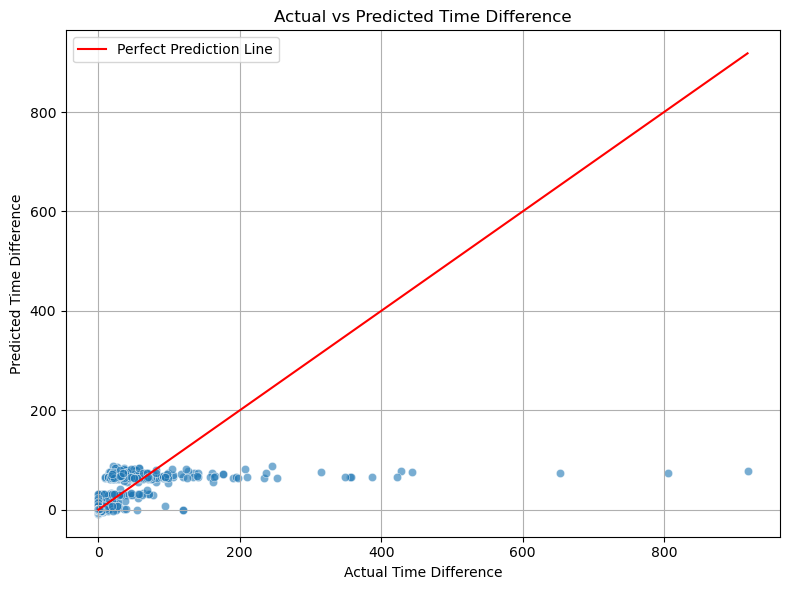

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
sns.lineplot(x=y_test, y=y_test, color='red', label='Perfect Prediction Line')

plt.xlabel('Actual Time Difference')
plt.ylabel('Predicted Time Difference')
plt.title('Actual vs Predicted Time Difference')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
# Get components
preprocessor = model.named_steps['preprocessor']
regressor = model.named_steps['regressor']

# Get feature names
num_features = numeric_features
cat_transformer = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = cat_transformer.get_feature_names_out(categorical_features)

all_feature_names = num_features + list(cat_features)

# Get coefficients
coefs = regressor.coef_

# Combine into DataFrame
import pandas as pd
feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefs,
    'Abs_Coefficient': np.abs(coefs)
}).sort_values(by='Abs_Coefficient', ascending=False)

print(feature_importance.head(15))


                                     Feature  Coefficient  Abs_Coefficient
18              SUB_TYPE_Outdoor Music Venue    52.800503        52.800503
19      SUB_TYPE_Private Sound Amplification   -13.611297        13.611297
20       SUB_TYPE_Public Sound Amplification   -13.279756        13.279756
17       SUB_TYPE_Government Amplified Sound   -11.970466        11.970466
13                MULTIPLE_START_DATES_False   -11.525299        11.525299
14                 MULTIPLE_START_DATES_True    11.525299        11.525299
9                         COUNCIL_DISTRICT_7    10.870608        10.870608
8                         COUNCIL_DISTRICT_6    -8.736389         8.736389
26      AMPLIFIED_SOUND_DISTRICT_Residential     7.967644         7.967644
16                 SUB_TYPE_Concrete Pouring    -7.843373         7.843373
27          AMPLIFIED_SOUND_DISTRICT_Unknown    -7.843373         7.843373
4                         COUNCIL_DISTRICT_2     7.025750         7.025750
6                        

C:\Users\nneom\AppData\Local\Temp\ipykernel_4780\1711602356.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Abs_Coefficient', y='Feature', data=top_features, palette='viridis')


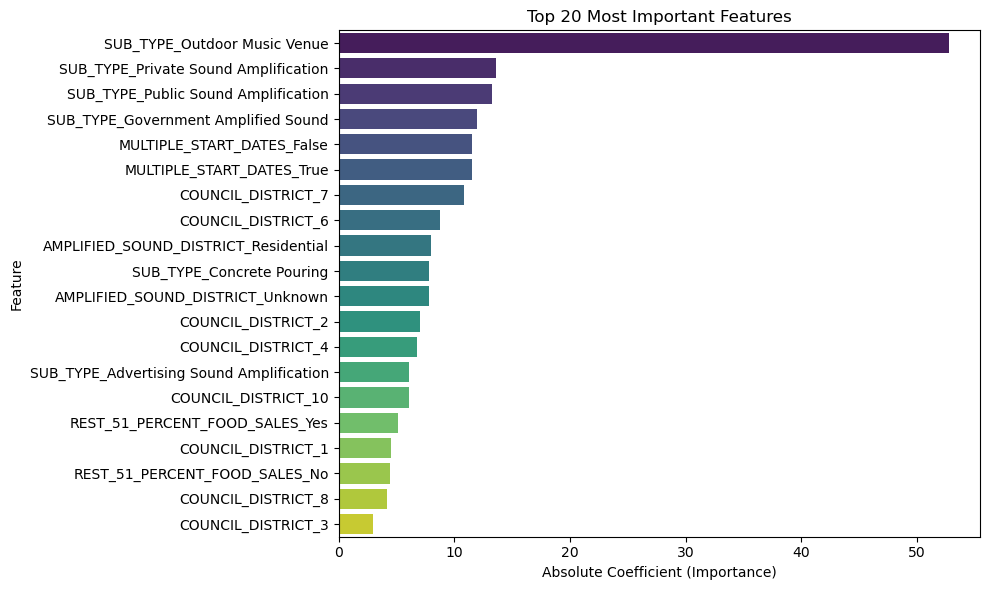

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

top_n = 20  # you can change this number
top_features = feature_importance.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x='Abs_Coefficient', y='Feature', data=top_features, palette='viridis')
plt.title(f'Top {top_n} Most Important Features')
plt.xlabel('Absolute Coefficient (Importance)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [ ]:
# capacity
'''

'''
cap_df = df[~df['CAPACITY'].isna()]
cap_df = cap_df.drop(columns=['END_HOURS_CONC_POUR_MON_SAT','END_HOURS_NEAR_HOME_FRI_SAT','END_HOURS_NEAR_HOME_SUN_THUR', 'END_HOURS_NOT_NEAR_HOME',
                              'START_HOURS_NEAR_HOME_FRI_SAT', 'START_HOURS_NEAR_HOME_SUN_THUR' ,'START_HOURS_NOT_NEAR_HOME', 'START_HOURS_CONC_POUR_MON_SAT',
                              'in_mon', 'issue_mon', 'in_year', 'issue_year'])

omv_time_cols = [
    'OMV_FRI_END_TIME', 'OMV_FRI_START_TIME',
    'OMV_MON_END_TIME', 'OMV_MON_START_TIME',
    'OMV_SAT_END_TIME', 'OMV_SAT_START_TIME',
    'OMV_SUN_END_TIME', 'OMV_SUN_START_TIME',
    'OMV_THU_END_TIME', 'OMV_THU_START_TIME',
    'OMV_TUE_END_TIME', 'OMV_TUE_START_TIME',
    'OMV_WED_END_TIME', 'OMV_WED_START_TIME'
]

for col in omv_time_cols:
    df[col] = df[col].fillna(df[col].median())


# cap_df['DECIBEL_LEVEL']


In [96]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

numeric_features = ['EVENT_YEAR', 'LATITUDE', 'LONGITUDE', 'OMV_FRI_END_TIME', 'OMV_FRI_START_TIME',
    'OMV_MON_END_TIME', 'OMV_MON_START_TIME',
    'OMV_SAT_END_TIME', 'OMV_SAT_START_TIME',
    'OMV_SUN_END_TIME', 'OMV_SUN_START_TIME',
    'OMV_THU_END_TIME', 'OMV_THU_START_TIME',
    'OMV_TUE_END_TIME', 'OMV_TUE_START_TIME',
    'OMV_WED_END_TIME', 'OMV_WED_START_TIME', 'SQUARE_FOOTAGE', 'DECIBEL_LEVEL']
categorical_features = ['ZIPCODE', 'COUNCIL_DISTRICT', 'MULTIPLE_START_DATES', 'SUB_TYPE', 'REST_51_PERCENT_FOOD_SALES', 'AMPLIFIED_SOUND_DISTRICT']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])



In [97]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

X_cap = cap_df.drop(columns=['time_diff'])
X_train_cap, X_test_cap, y_train_cap, y_test_cap = train_test_split(X_cap, cap_df['time_diff'], test_size=0.2, random_state=42)

# ---------- STEP 6: Fit the Model ----------
model.fit(X_train_cap, y_train_cap)

# ---------- STEP 7: Evaluate ----------
y_pred_cap = model.predict(X_test_cap)

print("R² score:", r2_score(y_test_cap, y_pred_cap))
print("Overall RMSE:", root_mean_squared_error(y_test_cap, y_pred_cap))


R² score: -0.045923564385547344
Overall RMSE: 48.14644647126042
